#### Example for getting spacecraft positions with heliopy

2022-09-01 00:00:00
2022-09-30 23:00:00


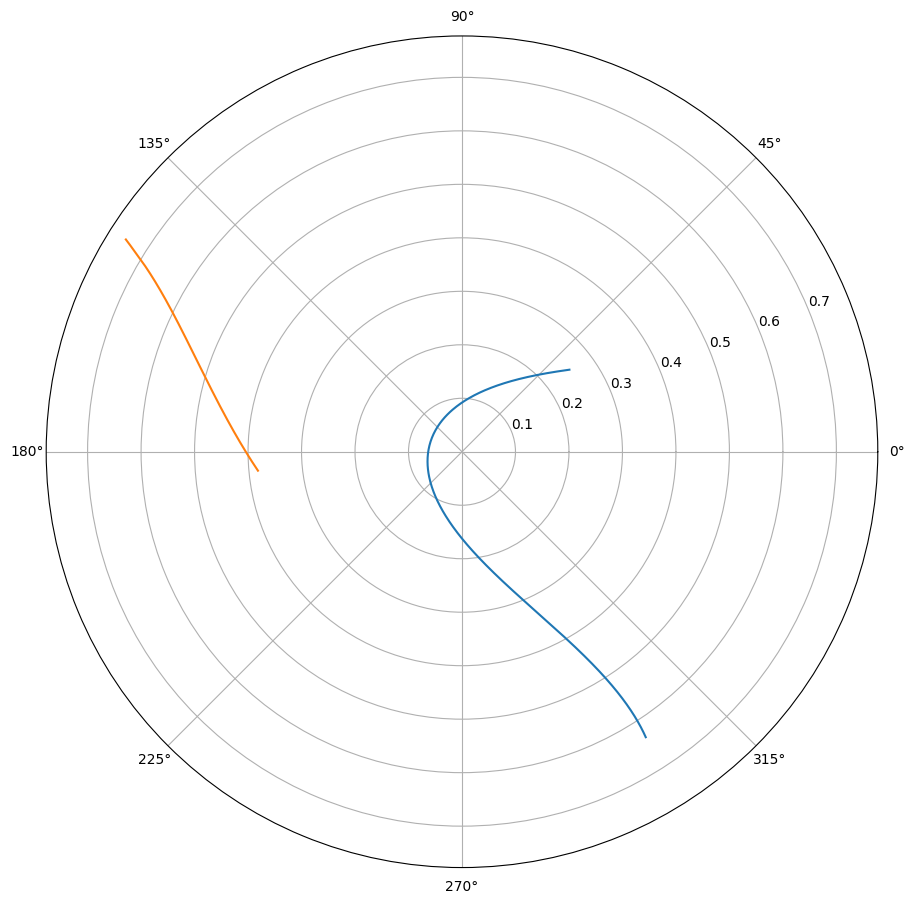

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import astropy
    

import heliopy.data.spice as spicedata
import heliopy.spice as spice


def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)



#any datetime object
starttime = datetime.datetime(2022, 9, 1)
endtime = starttime + timedelta(days=30)
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(hours=1)


#get PSP position
spice.furnish(spicedata.get_kernel('psp_pred'))
psp=spice.Trajectory('SPP')
psp.generate_positions(times, 'Sun','HEEQ')
psp.change_units(astropy.units.AU)
[psp_r, psp_lat, psp_lon]=cart2sphere(psp.x,psp.y,psp.z)


#get SolO position
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(times, 'Sun','HEEQ')
solo.change_units(astropy.units.AU)
[solo_r, solo_lat, solo_lon]=cart2sphere(solo.x,solo.y,solo.z)


fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')

plt.plot(psp_lon,psp_r)
plt.plot(solo_lon,solo_r)

print(times[0])
print(times[-1])